# 極性予測モデルを作る

In [4]:
ID = "UT-sei"

POPULATION_ID = "population"

#分析対象テキストデータ
target_texts_file = "Only_Texts/Responses/%s.txt"%ID

#母集団テキストデータ
population_texts_file = "Only_Texts/population-sample.txt"

#分析対象の極性教師データ
target_teacher_file = "Sentiment-Teacher/%s.txt"%ID

#母集団の極性教師データ
population_teacher_file = "Sentiment-Teacher/%s.txt"%POPULATION_ID

#アマゾンの極性教師データ
amazon_teacher_file_pos = "Amazon/positive.txt"
amazon_teacher_file_neg = "Amazon/negative.txt"

#TFIDFモデルの保存
tfidf_model_file = "Models/Tfidf/%s-from-%s.model"%(ID, POPULATION_ID)

#分析器の保存
classifer_model_file = "Models/Classifers/%s-from-%s.model"%(ID, POPULATION_ID)

#最適化にあたるスコアの各データの比率（どのデータの精度を優先するか）
#分析対象データの過学習を避けるため
TARGET_PRIORITY = 0.5
POPULATION_PRIORITY = 0.3
AMAZON_PRIORITY = 0.2

## ファイル読み込み

In [5]:
import pandas as pd

### テキストデータ群

In [6]:
df_target_texts = pd.read_table(target_texts_file, names=["Texts"])
df_population_texts = pd.read_table(population_texts_file, names=["Texts"])


df_target_texts.shape, df_population_texts.shape

((16898, 1), (49974, 1))

### 教師データ群

In [7]:
df_target = pd.read_table(target_teacher_file, names=["Texts", "Sentiment"], index_col=None)

df_target.shape

(267, 2)

In [8]:
df_population = pd.read_table(population_teacher_file, names=["Texts", "Sentiment"], index_col=None)

df_population.shape

(1060, 2)

In [25]:
df_amazon_pos = pd.read_table(amazon_teacher_file_pos, names=["Texts"], index_col=None)
df_amazon_neg = pd.read_table(amazon_teacher_file_neg, names=["Texts"], index_col=None)

df_amazon_texts = pd.concat([df_amazon_pos, df_amazon_neg])

df_amazon_pos["Sentiment"] = "pos"
df_amazon_neg["Sentiment"] = "neg"

df_amazon = pd.concat([df_amazon_pos, df_amazon_neg])

df_amazon_texts.shape, df_amazon.shape

((2000, 1), (2000, 2))

### 全テキストデータの作成

In [27]:
df_all_texts = pd.concat([df_target_texts, df_population_texts, df_amazon_texts])

df_all_texts.head(5)

,Texts
0,>>109 いや、気にせず自由に作ってくれ。
1,>>23 OK(^ω^) そういう漏れも高卒。 東大なんか目じゃないお。
2,>>360 就職は勉強とは関係ないよ。 もちろん、在学中に司法試験や会計士試験に受かれ...
3,>>54 東大生が書いた頭が良くなる算数の教科書 ～東大脳は誰にでも作れる～ >「東大...
4,>>189 つーか東京商科は実業人養成学校として始まったんだから サラリーマン養成所と...


## 学習データと評価データの切り分け

In [11]:
from sklearn.model_selection import train_test_split

TEST_RATIO = 0.2

#各データの重みづけ
TARGET_WEIGHT       = 5
POPULATION_WEIGHT   = 3
AMAZON_WEIGHT       = 1

#切り分け
df_target_train, df_target_valid = train_test_split(df_target, test_size=TEST_RATIO, random_state=334)
df_population_train, df_population_valid = train_test_split(df_population, test_size=TEST_RATIO, random_state=334)
df_amazon_train, df_amazon_valid = train_test_split(df_amazon, test_size=TEST_RATIO, random_state=334)

df_all_train = pd.concat([df_target_train, df_population_train, df_amazon_train])
df_all_valid = pd.concat([df_target_valid, df_population_valid, df_amazon_valid])

df_all = pd.concat([df_all_train, df_all_valid])

#重みづけ配列
data_weights = []
def get_wights(target_weight, population_weight, amazon_weight):
    data_weights = []

    for _ in range(len(df_target_train)):
        data_weights.append(target_weight)
    for _ in range(len(df_population_train)):
        data_weights.append(population_weight)
    for _ in range(len(df_amazon_train)):
        data_weights.append(amazon_weight)

    return data_weights

data_weights = get_wights(5,3,1)

df_all_train.shape, df_all_valid.shape, len(data_weights)

((2661, 2), (666, 2), 2661)

## TFIDFモデルを作成

In [12]:
import MeCab
from sklearn.feature_extraction.text import TfidfVectorizer

#形態素分解＋原形をリスト化
def tokenize(text):
    output = []
    
    tagger = MeCab.Tagger()
    node = tagger.parseToNode(text)

    while node:
        #原形を記録
        features = node.feature.split(",")
        if len(features) >= 8:
            output.append(features[7])
        else:
            output.append(node.surface)

        node = node.next
    
    return output

print(tokenize("オレンジ今日も食べてみたけどまだ酸っぱくて泣いた"))

#単語ベクトル作成+TFIDFモデルの作成
vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1,3), min_df=20, sublinear_tf=True)
tfidf_fit = vectorizer.fit(df_all_texts["Texts"].values.astype("U"))

#各データフレームをTFIDFのspycy行列に
num_target_train     = tfidf_fit.transform(df_target_train["Texts"].values.astype("U"))
num_target_valid     = tfidf_fit.transform(df_target_valid["Texts"].values.astype("U"))
num_population_train = tfidf_fit.transform(df_population_train["Texts"].values.astype("U"))
num_population_valid = tfidf_fit.transform(df_population_valid["Texts"].values.astype("U"))
num_amazon_train     = tfidf_fit.transform(df_amazon_train["Texts"].values.astype("U"))
num_amazon_valid     = tfidf_fit.transform(df_amazon_valid["Texts"].values.astype("U"))

num_all_train        = tfidf_fit.transform(df_all_train["Texts"].values.astype("U"))
num_all_valid        = tfidf_fit.transform(df_all_valid["Texts"].values.astype("U"))

['*', 'オレンジ-orange', '今日', 'も', '食べる', 'て', '見る', 'た', 'けれど', '未だ', '酸っぱい', 'て', '泣く', 'た', '*']


c:\Users\brigh\anaconda3\envs\jpnlp\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## ロジスティック回帰による分類モデルを作成

In [13]:
from sklearn.linear_model import SGDClassifier

### 学習

In [14]:
#spycy行列を普通の行列に
x_train             = num_all_train.toarray()
x_valid             = num_all_valid.toarray()    
x_target_valid      = num_target_valid.toarray()
x_population_valid  = num_population_valid.toarray()
x_amazon_valid      = num_amazon_valid.toarray()

In [15]:
#分類モデル
classifer = SGDClassifier(loss="log", penalty="l2", random_state=334)

#最適化スコアを取得
def get_total_score(classifer : SGDClassifier):
    amazon_score = classifer.score(x_amazon_valid,          df_amazon_valid["Sentiment"])
    population_score = classifer.score(x_population_valid,  df_population_valid["Sentiment"])
    target_score = classifer.score(x_target_valid,          df_target_valid["Sentiment"])

    return amazon_score*AMAZON_PRIORITY + population_score*POPULATION_PRIORITY + target_score*TARGET_PRIORITY

#学習・最適なデータ重み比を走査
best = None
max_score = 0
for target in range(0,5,1):
    for population in range(0,5,1):
        for amazon in range(0,5,1):
            data_weights = get_wights(target, population, amazon)
            classifer = SGDClassifier(loss="log", penalty="l2", random_state=334)
            classifer.fit(x_train, df_all_train["Sentiment"], sample_weight=data_weights)
            score = get_total_score(classifer)
            if max_score < score:
                best = (target, population, amazon)
                max_score = score

classifer = SGDClassifier(loss="log", penalty="l2", random_state=334)
data_weights = get_wights(best[0], best[1], best[2])
classifer.fit(x_train, df_all_train["Sentiment"], sample_weight=data_weights)

best, max_score

((4, 2, 1), 0.5774430468204053)

### 評価

In [16]:
#評価データ
target_score        = classifer.score(x_target_valid,       df_target_valid["Sentiment"])
population_score    = classifer.score(x_population_valid,   df_population_valid["Sentiment"])
amazon_score        = classifer.score(x_amazon_valid,       df_amazon_valid["Sentiment"])

target_score, population_score, amazon_score

(0.5370370370370371, 0.47641509433962265, 0.83)

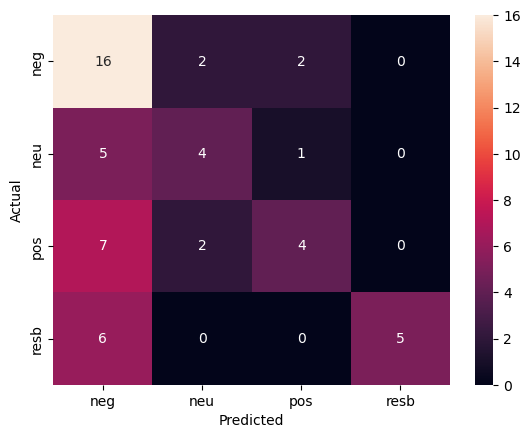

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predicted = classifer.predict(x_target_valid)

conf_mat = confusion_matrix(df_target_valid["Sentiment"], predicted)
sns.heatmap(conf_mat, annot=True, fmt="d",
                xticklabels=classifer.classes_, yticklabels=classifer.classes_)

plt.ylabel("Actual")
plt.xlabel("Predicted")

plt.show()

## 保存


In [18]:
import pickle

#TFIDFモデル
with open(tfidf_model_file, "wb") as f:
    pickle.dump(tfidf_fit, f)

#分類モデル
with open(classifer_model_file, "wb") as f:
    pickle.dump(classifer, f)